## Machine Learning
### Confidence Intervals and Bootstrapping

Bootstrapping can be used to build confidence intervals around the inferred linear model parameters. In this notebook:
- Learn how to use bootstrapping to generate new sample datasets
- Estimate our model parameter on these new sample datasets
- Quantify the variance of our estimate using confidence intervals

### Setup

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_cn",
            "user_key": "y1x3mpx5",
        },
    ).render()


feedback_prefix = "W1D2_T3"


[notice] A new release of pip is available: 23.1.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [6]:
# @title Plotting Functions

def plot_original_and_resample(x, y, x_, y_):
  """ Plot the original sample and the resampled points from this sample.

  Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
    x_ (ndarray): An array of shape (samples,) with a subset of input values from x
    y_ (ndarray): An array of shape (samples,) with a the corresponding subset
      of measurement values as x_ from y

  """
  fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
  ax1.scatter(x, y)
  ax1.set(title='Original', xlabel='x', ylabel='y')

  ax2.scatter(x_, y_, color='c')

  ax2.set(title='Resampled', xlabel='x', ylabel='y',
          xlim=ax1.get_xlim(), ylim=ax1.get_ylim())
  plt.show()

### Introduction

Previously we have estimated model paramaters to fit an observed dataset. We have optimized some criterion:
- Minimize MSE
- Maximize likelihood
But how good is the estimate? How confident are we that it will generalize well to new data?

In the case where we cannot just collect new data to test the model, we must find a way to measure our confidence. We do this by _bootstrapping_.
### Bootstrapping

_Bootstrapping_ is a method to measure confidence/uncertainty on our estimated parameters. 

__Method__: Generate many new synthetic datasets from the initial true dataset by randomly sampling from it, then finding estimators for each one of these new datasets, and finally looking at the distribution of all these estimators to quantify our confidence.

Note: each new resampled datasets will be the same size as our original one, with the new data points sampled with replacement i.e. we can repeat the same data point multiple times.

We start again with our noisy samples along the line $y_{i}=1.2x_{i}+ϵ_{i}$
, but this time, we only use half the data points as last time (15 instead of 30).

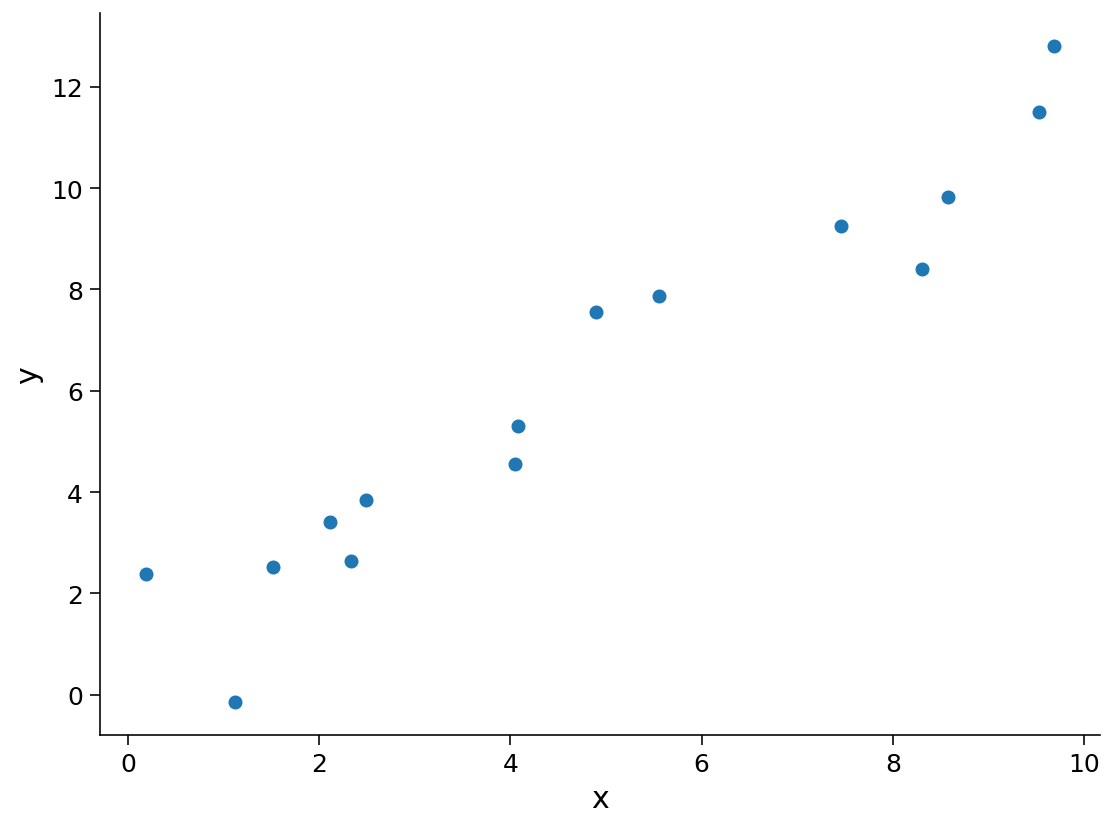

In [7]:
# setting a fixed seed to our random number generator ensures we will always
# get the same psuedorandom number sequence
np.random.seed(121)

# setting arbitrary paramaters
theta = 1.2
n_samples = 15

# draw x and then calculate y
x = 10 * np.random.rand(n_samples)  # sample from a uniform distribution over [0,10]
noise = np.random.randn(n_samples)  # sample from a standard normal distribution
y = theta * x + noise

fig, ax = plt.subplots()
ax.scatter(x, y)  # produces a scatter plot
ax.set(xlabel='x', ylabel='y');

### Resampling Dataset with Replacement

Now we will implement a method to resample a dataset with replacement. The method accepts $x$ and $y$ arrays. It should return a new set of $x^{'}$ and $y^{'}$ arrays that are created by randomly sampling from the originals.

We can then compare the original dataset to a resampled dataset.

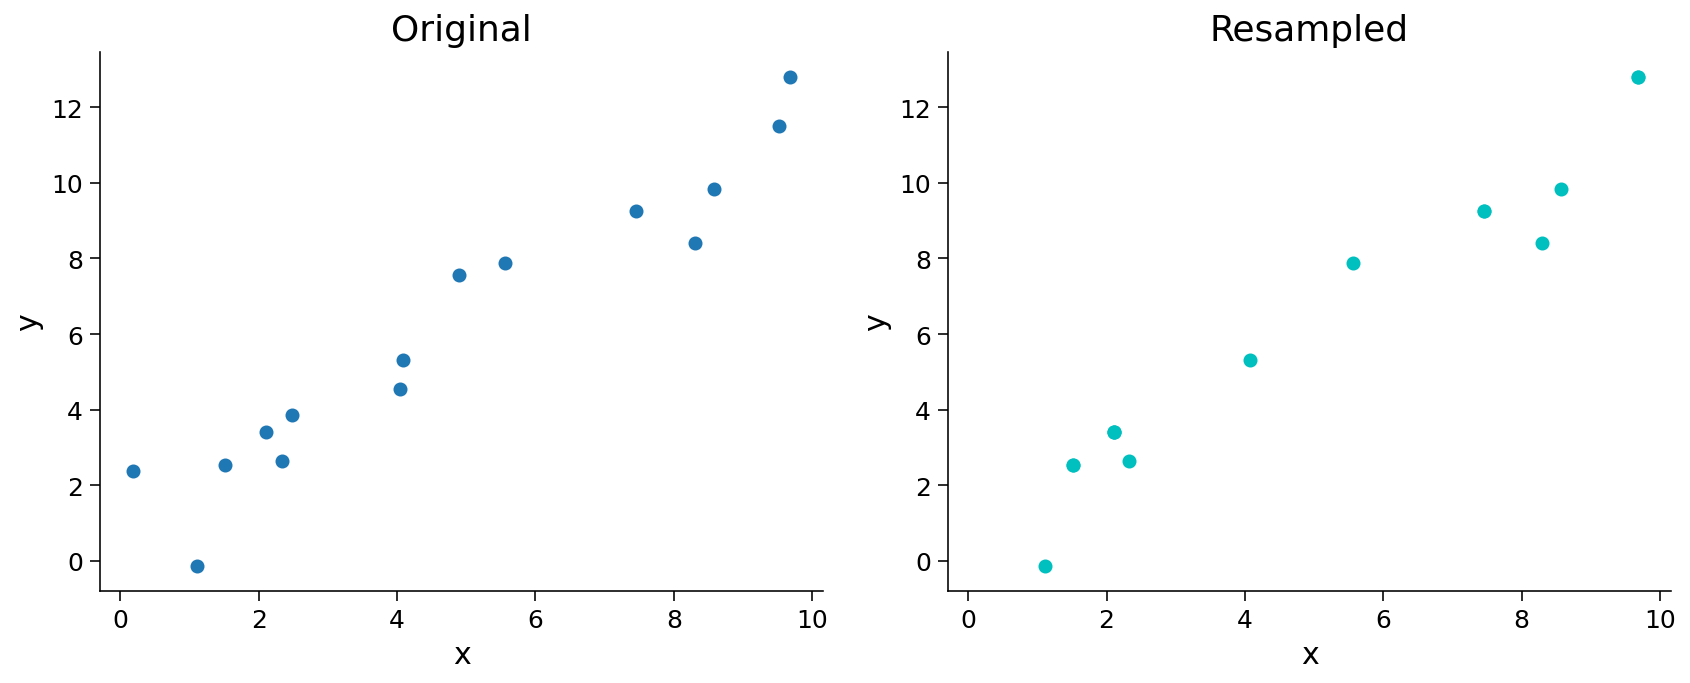

In [8]:
def resample_with_replacement(x, y):
  """Resample data points with replacement from the dataset of `x` inputs and
  `y` measurements.

  Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.

  Returns:
    ndarray, ndarray: The newly resampled `x` and `y` data points.
  """

  # Get array of indices for resampled points
  sample_idx = np.random.choice(len(x), size=len(x), replace=True)

  # Sample from x and y according to sample_idx
  x_ = x[sample_idx]
  y_ = y[sample_idx]

  return x_, y_

x_, y_ = resample_with_replacement(x, y)

plot_original_and_resample(x, y, x_, y_)

In the resampled plot on the right, the actual number of points is the same, but some have been repeated so they only display once.

Now that we have a way to resample the data, we can use that in the full bootstrapping process.

### Bootstrap Estimates

Now we will implement a method to run the bootstrap process of generating a set of $\hat{\theta}$ values from a dataset of inputs $(x)$ and measurements $(y)$.

In [9]:
def solve_normal_eqn(x, y):
  """Solve the normal equations to produce the value of theta_hat that minimizes
    MSE.

    Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
    thata_hat (float): An estimate of the slope parameter.

  Returns:
    float: the value for theta_hat arrived from minimizing MSE
  """
  theta_hat = (x.T @ y) / (x.T @ x)
  return theta_hat

Below we call the functions <font color=blue>solve_normal_eqn</font> and <font color=blue>resample_with_replacement</font> within the <font color=blue>bootstrap_estimates</font> function.

In [10]:
def bootstrap_estimates(x, y, n=2000):
  """Generate a set of theta_hat estimates using the bootstrap method.

  Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
    n (int): The number of estimates to compute

  Returns:
    ndarray: An array of estimated parameters with size (n,)
  """
  theta_hats = np.zeros(n)

  # Loop over number of estimates
  for i in range(n):

    # Resample x and y
    x_, y_ = resample_with_replacement(x, y)

    # Compute theta_hat for this sample
    theta_hats[i] = solve_normal_eqn(x, y)

  return theta_hats


# Set random seed
np.random.seed(123)

# Get bootstrap estimates
theta_hats = bootstrap_estimates(x, y, n=2000)
print(theta_hats[0:5])

[1.2334971 1.2334971 1.2334971 1.2334971 1.2334971]


We can now visualize all the potential models (models computed with different resampling) together to see how distributed they are.

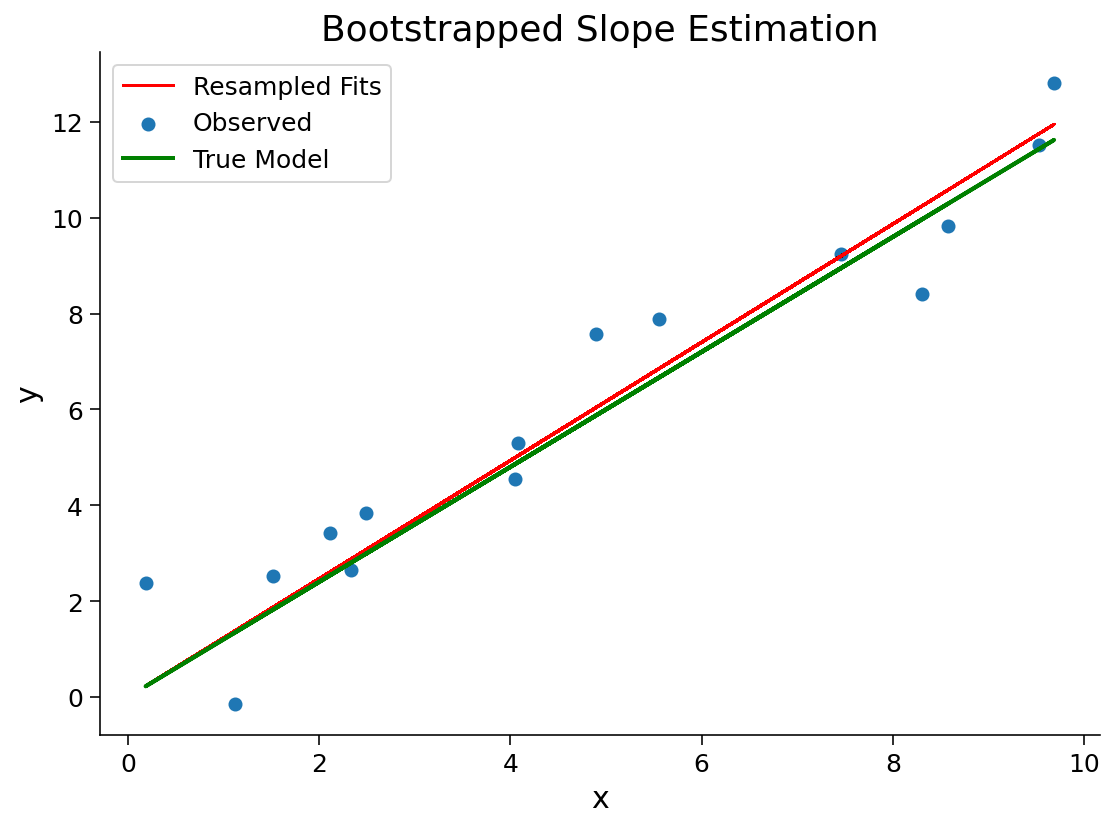

In [11]:
fig, ax = plt.subplots()

# For each theta_hat, plot model
theta_hats = bootstrap_estimates(x, y, n=2000)
for i, theta_hat in enumerate(theta_hats):
  y_hat = theta_hat * x
  ax.plot(x, y_hat, c='r', alpha=0.01, label='Resampled Fits' if i==0 else '')

# Plot observed data
ax.scatter(x, y, label='Observed')

# Plot true fit data
y_true = theta * x
ax.plot(x, y_true, 'g', linewidth=2, label='True Model')

ax.set(
  title='Bootstrapped Slope Estimation',
  xlabel='x',
  ylabel='y'
)

# Change legend line alpha property
handles, labels = ax.get_legend_handles_labels()
handles[0].set_alpha(1)

ax.legend()
plt.show()

The bootstrapped estimates spread around the true model, as we would have hoped. 

_Note:_ here we have the luxury to know the ground truth value for $\theta$, but in applications we are trying to guess it from data. Therefore, assessing the quality of estimates based on finite data is a task of fundamental importance in data analysis. 

### Confidence Intervals

We now need to quanitfy the uncertainty on our estimated slope (resampled fits). This is where we compute _confidence intervals_ (CIs) from the bootstrapped estimates. 

The most direct approach is to compute percentiles from the empirical distribution of bootstrapped estimates. Note that this is widely applicable as we are not assuming that this empirical distribution is Gaussian.

mean = 1.23, std = 0.00


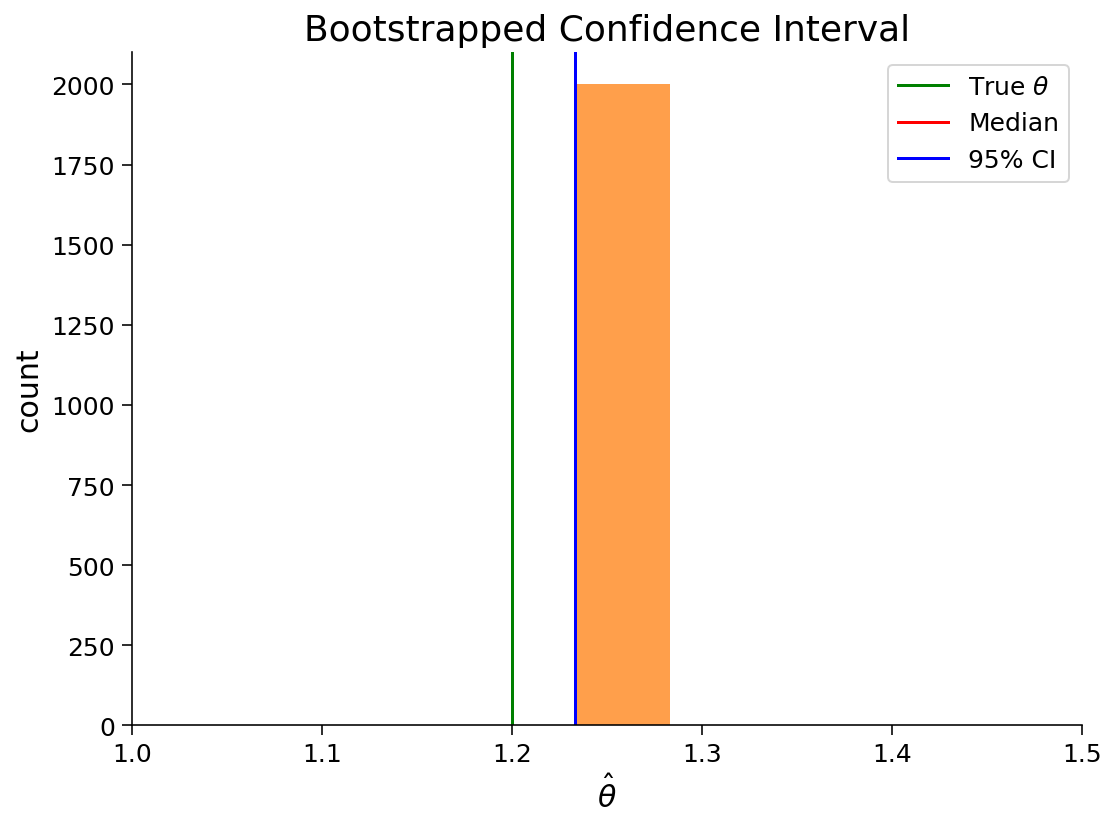

In [12]:
# @markdown Execute this cell to plot bootstrapped CI

theta_hats = bootstrap_estimates(x, y, n=2000)
print(f"mean = {np.mean(theta_hats):.2f}, std = {np.std(theta_hats):.2f}")

fig, ax = plt.subplots()
ax.hist(theta_hats, bins=20, facecolor='C1', alpha=0.75)
ax.axvline(theta, c='g', label=r'True $\theta$')
ax.axvline(np.percentile(theta_hats, 50), color='r', label='Median')
ax.axvline(np.percentile(theta_hats, 2.5), color='b', label='95% CI')
ax.axvline(np.percentile(theta_hats, 97.5), color='b')
ax.legend()
ax.set(
    title='Bootstrapped Confidence Interval',
    xlabel=r'$\hat{{\theta}}$',
    ylabel='count',
    xlim=[1.0, 1.5]
)
plt.show()

Looking at the distribution of bootstrapped $\hat{\theta}$ values, we see that the true $\theta$ falls well within the 95% confidence interval, which is reassuring. We also see that the value does not fall within the confidence interval. From this we would reject the hypothesis that the slope was 1.

### Summary
- Bootstrapping is a resampling procedure that allows to build confidence intervals around inferred parameter values
- It is a widely applicable and very practical method that relies on computational power and pseudo-random number generators (as opposed to more classical approaches than depend on analytical derivations)